In [1]:
import sys
sys.path.append("..")

# Reload modules in /src/ when changed
%load_ext autoreload
%autoreload 2

from src import BarrierMethod

import pandas as pd
import numpy as np
import ffn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 2)

# Data

[*********************100%%**********************]  1 of 1 completed


<Axes: title={'center': 'spy'}, xlabel='Date'>

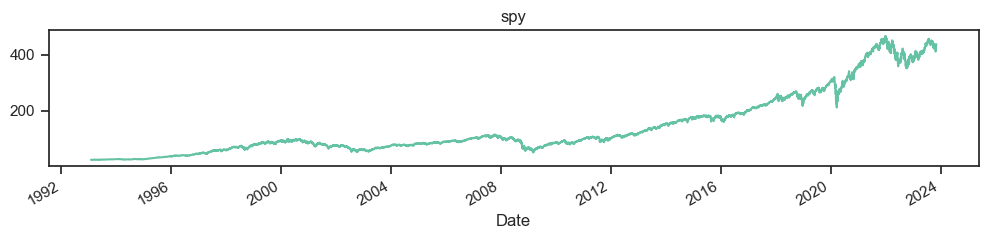

In [2]:
ticker = "spy"

data = ffn.get(ticker)[ticker]
rets = data.pct_change()

data.plot(title=ticker)

# Comparison of different transformations

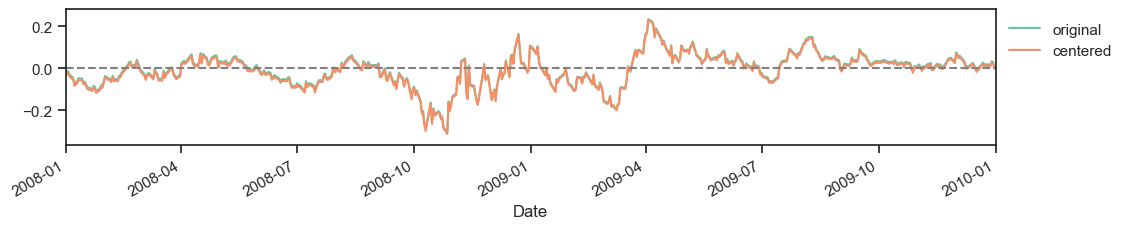

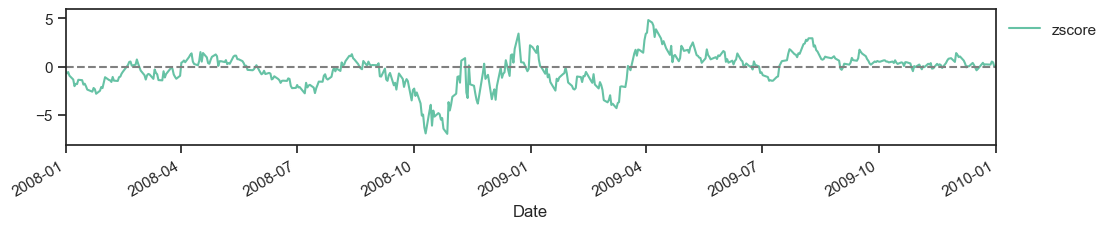

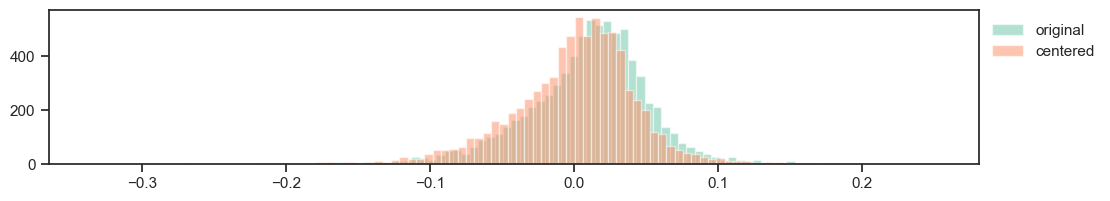

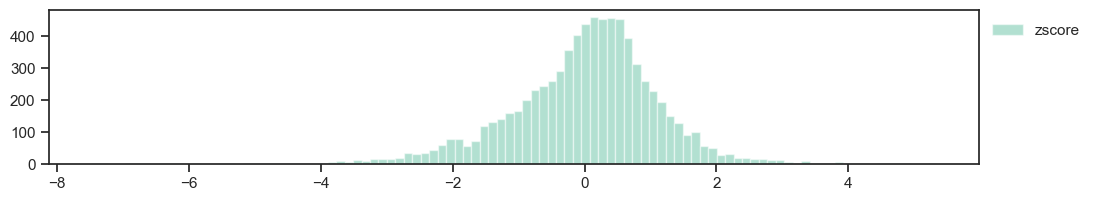

In [3]:
n = 21

comparison = pd.concat([
    data.pct_change(n).rename("original"),
    (data.pct_change(n) - data.pct_change(n).expanding().mean()).rename("centered"),
    ((data.pct_change(n) - data.pct_change(n).expanding().mean()) / data.pct_change(n).expanding().std()).rename("zscore"),
], axis=1).dropna()


start_date = pd.Timestamp("2008-01-01")
end_date = pd.Timestamp("2010-01-01")

comparison["original"].plot()
comparison["centered"].plot()
plt.xlim(start_date, end_date)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.axhline(0, c="grey", ls="--")
plt.show()

comparison["zscore"].plot()
plt.xlim(start_date, end_date)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.axhline(0, c="grey", ls="--")
plt.show()

bins=100
plt.hist(comparison["original"], bins=bins, alpha=0.5, label="original")
plt.hist(comparison["centered"], bins=bins, alpha=0.5, label="centered")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()


plt.hist(comparison["zscore"], bins=bins, alpha=0.5, label="zscore")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

# TripleBarrierMethod

## Setup

In [4]:
n = 21
n_barriers = 2
barrier = data.pct_change(n).quantile(0.68)  # approx. a 1σ interval, assuming normal distributed returns

### Identify a barrier

,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
spy,-0.327513,-0.045917,-0.022185,-0.006236,0.004874,0.013638,0.022292,0.03123,0.040676,0.05636,0.25185


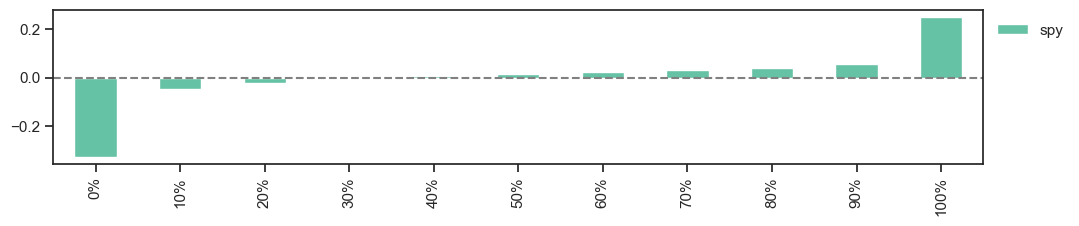

In [5]:
percentiles = data.pct_change(n).describe(percentiles=np.linspace(0,1,11)).drop(["count", "mean", "std", "min", "max"])
display(percentiles.to_frame().T)
percentiles.plot.bar()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.axhline(0, c="grey", ls="--")
plt.show()

## Using Triple Barrier Method

### Not centered returns: default

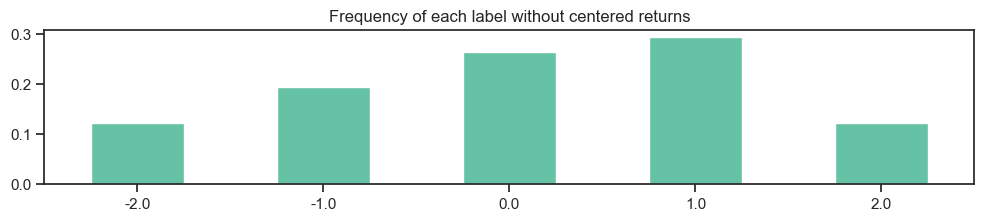

In [6]:
barrier_method = BarrierMethod(returns=rets, n=n, barrier=barrier, n_barriers=n_barriers, center=False)
barrier_method.labels.value_counts(normalize=True).sort_index().plot.bar(rot=0, title="Frequency of each label without centered returns")
plt.gcf().savefig("../figures/barrier_freq.png")
plt.show()

### Centered returns:

The labels are approx. normal distributed. This results in us staying neutral (0) most of the time,

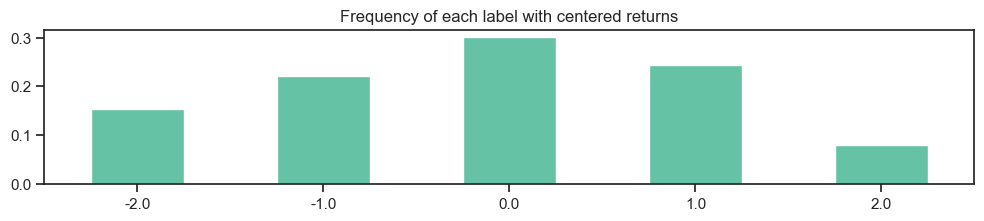

In [7]:
barrier_method = BarrierMethod(returns=rets, n=n, barrier=barrier, n_barriers=n_barriers, center=True)
barrier_method.labels.value_counts(normalize=True).sort_index().plot.bar(rot=0, title="Frequency of each label with centered returns")
plt.gcf().savefig("../figures/barrier_freq_centered.png")
plt.show()

# Additional analysis:

In [8]:
n = 21
n_barriers = 2
barrier_method = BarrierMethod(returns=rets, n=n, barrier=barrier, n_barriers=n_barriers, center=True)

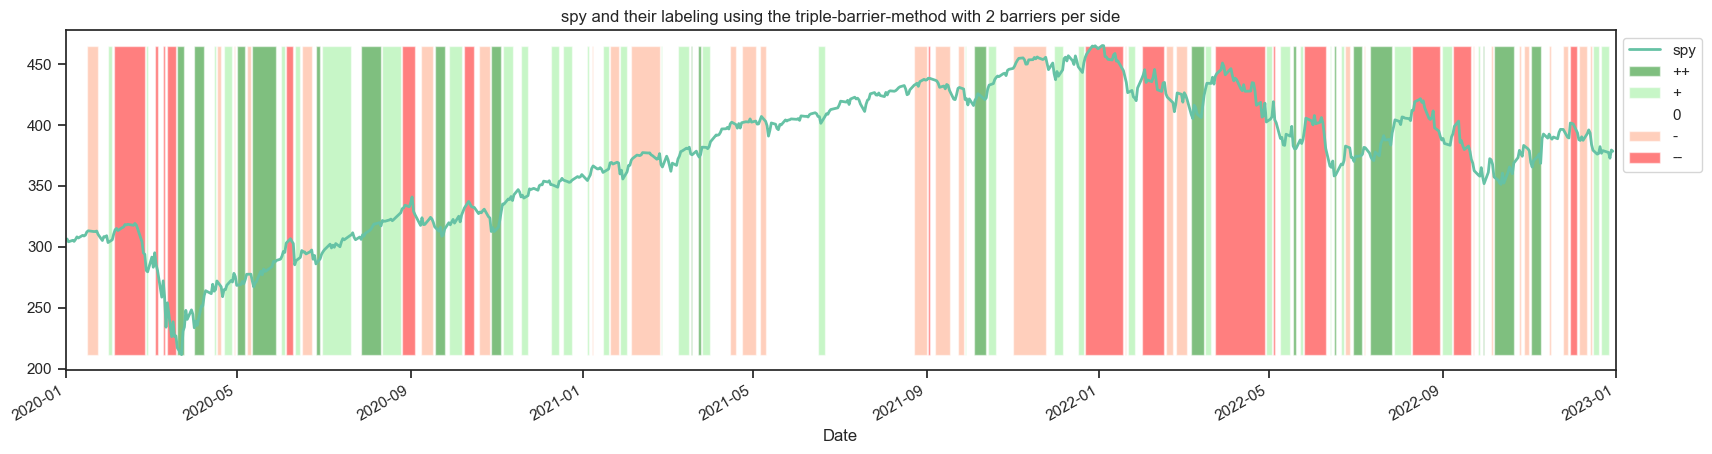

In [9]:
start_date = pd.Timestamp("2020-01-01")
end_date = pd.Timestamp("2023-01-01")

labels = barrier_method.labels.rename("label")
idx = labels.index.intersection(data.index)

plot_df = pd.concat([data, labels], axis=1).loc[idx].dropna()
start_date, end_date = max(start_date, plot_df.index.min()), min(end_date, plot_df.index.max())
plot_df = plot_df.loc[start_date:end_date]
figsize = (20, 5)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f"{ticker} and their labeling using the triple-barrier-method with 2 barriers per side")
plot_df[ticker].plot(ax=ax, linewidth=2)
ylim = (plot_df[ticker].min(), plot_df[ticker].max())
ax.fill_between(plot_df[ticker].index, ylim[0], ylim[1], where=plot_df["label"]==2,facecolor='green', alpha=0.5, label="++")
ax.fill_between(plot_df[ticker].index, ylim[0], ylim[1], where=plot_df["label"]==1,facecolor='lightgreen', alpha=0.5, label="+")
ax.fill_between(plot_df[ticker].index, ylim[0], ylim[1], where=plot_df["label"]==0,facecolor='white', alpha=0.5, label="0")
ax.fill_between(plot_df[ticker].index, ylim[0], ylim[1], where=plot_df["label"]==-1,facecolor='lightsalmon', alpha=0.5, label="-")
ax.fill_between(plot_df[ticker].index, ylim[0], ylim[1], where=plot_df["label"]==-2,facecolor='red', alpha=0.5, label="--")
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xlim(start_date, end_date)
plt.show()

<div class="alert alert-block alert-danger"><b>Info: </b>matplotlibs function .fill_between() is showing empty spaces between consecutive changes. The number of label changes is less than shown here.</div>

In [10]:
print(f"Changes per year: {(labels != labels.shift()).groupby(labels.index.year).sum().mean().round(2)}")
print("\nTransition probabilities:\n")
barrier_method.transition_probabilities.style.format( "{:.1%}")

Changes per year: 61.39

Transition probabilities:



To,-2,-1,0,1,2
From,,,,,
-2,83.6%,11.5%,0.0%,3.4%,1.4%
-1,7.1%,72.5%,8.6%,7.9%,3.9%
0,0.0%,7.7%,81.5%,10.7%,0.0%
1,3.4%,6.4%,14.7%,69.2%,6.4%
2,1.5%,5.0%,0.8%,25.9%,66.8%


In [11]:
barrier_method.time_since_last_crossing.tail(10)

,-2,-1,1,2
Date,,,,
2023-10-25,8,1,22,84
2023-10-26,9,0,23,85
2023-10-27,10,0,24,86
2023-10-30,11,0,25,87
2023-10-31,12,0,26,88
2023-11-01,13,0,0,89
2023-11-02,14,0,1,90
2023-11-03,15,0,2,91
2023-11-06,16,0,3,92


:1: UserWarning: The selected date '2022-08-21' is not inside the attribute 'returns'.The next available date is '2022-08-22'.


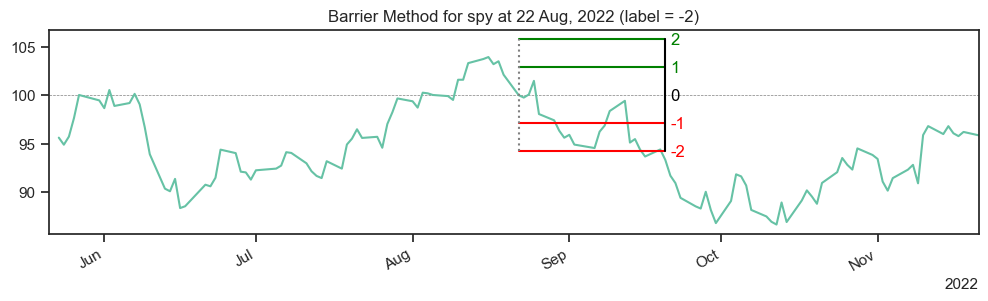

<Figure size 1200x200 with 0 Axes>

In [12]:
barrier_method.plot_at_date("2022-08-21")
plt.gcf().savefig("../figures/barrier_method_example.png")
plt.show()